
## 1. 项目介绍
> 来自Kaggle的数据集包含了泰坦尼克号上 2224 名乘客和船员中 891 名的人口学数据和乘客基本信息。本项目目的是分析有哪些因素会让船上的人生还率更高？


## 2. 数据清理
### 2.1. 检查数据完整性

In [25]:
import pandas as pd
import numpy as np


# 读取csv文件
filename = "titanic_data.csv"
df = pd.read_csv(filename)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


### 2.2. 整理数据
> 1. 对Age的缺失值做了删除处理，因为年龄的平均值为23，标准差为17，用平均值、中位数或者众数代替都不妥。
2. 删除Cabin和Embarked列，因为在这个项目中我们不调查这两个因素，而且他们也有缺失

In [26]:
# 清理数据
def format_df(df):
    # 删除年龄为空的行
    df = df[pd.notnull(df['Age'])]
    # 删除Carbin列
    df = df.drop('Cabin', 1)    
    # 删除Embarked列
    df = df.drop('Embarked', 1)   
    # 转换年龄为浮点型
    df["Age"] = df["Age"].apply(float)
    return df


df = format_df(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 714 entries, 0 to 890
Data columns (total 10 columns):
PassengerId    714 non-null int64
Survived       714 non-null int64
Pclass         714 non-null int64
Name           714 non-null object
Sex            714 non-null object
Age            714 non-null float64
SibSp          714 non-null int64
Parch          714 non-null int64
Ticket         714 non-null object
Fare           714 non-null float64
dtypes: float64(2), int64(5), object(3)
memory usage: 61.4+ KB


> 增加age_sex列，小于等于18岁的青少年为"Child"，大于18岁男子为"Man"，大于18岁女子为"Woman"。

In [27]:
def append_age_sex_column(c):
    if c["Age"] > 18:
        if c["Sex"] == "male":
            return "man"
        elif c["Sex"] == "female":
            return "woman"
        else:
            return np.NaN
    elif 0 < c["Age"] <= 18:
        return "child"
    else:
        return np.NaN


# 增加age_sex列（小于等于18岁的青少年为"Child"，大于18岁男子为"Man"，
# 大于18岁女子为"Woman")
df["Age_Sex"] = df.apply(append_age_sex_column, axis=1)

def calc_survival(df, key, *value):
    if key == "age":       
        series = df[(df.Age > value[0])
                   & (df.Age <= value[1])]["Survived"]
    elif key == "sex":
        series = df[df.Sex == value[0]]["Survived"]
    elif key == "level":
        series = df[df.Pclass == value[0]]["Survived"]
    elif key == "age_sex":
        series = df[df.Age_Sex == value[0]]["Survived"]
    elif key == "age_sex_level":
        series = df[(df.Age_Sex == value[0])
                    & (df.Pclass == value[1])]["Survived"]
    
    
    return series.sum(), series.shape[0], series.sum() / (series.shape[0] * 1.0)

df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Age_Sex
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,man
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,woman
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,woman
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,woman
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,man


## 3. 分析数据
### 3.1. 按age组进行分析
#### 3.1.1. 分组方式
> 小于等于18岁的一组，大于18岁为一组

#### 3.1.2. 分析结果
> 从图中可以看出，儿童有139名，成人有575名，其中儿童的生还率>成人的生还率

Populating the interactive namespace from numpy and matplotlib


array([<matplotlib.axes._subplots.AxesSubplot object at 0x117bd9ef0>], dtype=object)

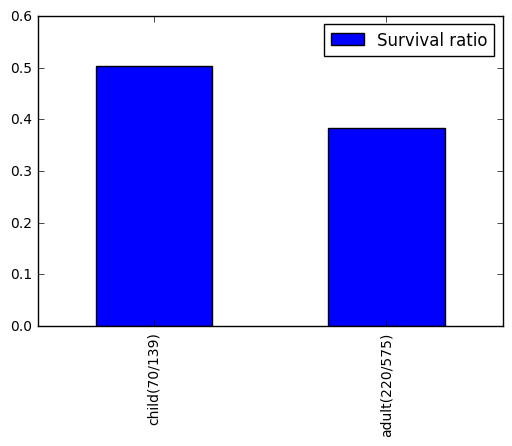

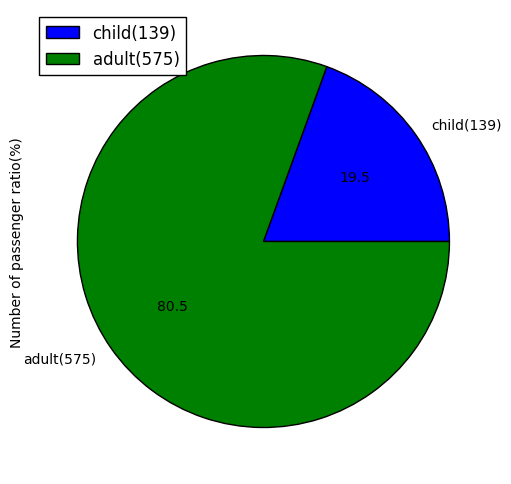

In [28]:
a1, a2, a3 = calc_survival(df, "age", 0, 18)
b1, b2, b3 = calc_survival(df, "age", 18, 100)
age_group_df = pd.DataFrame(
    data={"Survival ratio": [a3, b3]},
    index=["child", "adult"]
)


%pylab inline
import matplotlib.pyplot as plt

# 绘制直方图
age_group_df.index = [
    "child({0}/{1})".format(a1, a2), "adult({0}/{1})".format(b1, b2)
]
age_group_df.plot(kind="bar")

# 绘制饼图
age_num_group_df = pd.DataFrame(
    data={"Number of passenger ratio(%)": [a2, b2]},
   index=["child({0})".format(a2), "adult({0})".format(b2)]
)
age_num_group_df.plot.pie(subplots=True, autopct='%.1f', figsize=(6, 6))

### 3.2. 按sex组进行分析
#### 3.2.1. 分组方式
> 男性为一组，女性为一组

#### 3.2.2. 分析结果
> 从图中可以看出，男性有577名，女性有314名，其中女性的生还率远远>男性的生还率

Populating the interactive namespace from numpy and matplotlib


array([<matplotlib.axes._subplots.AxesSubplot object at 0x117bd9128>], dtype=object)

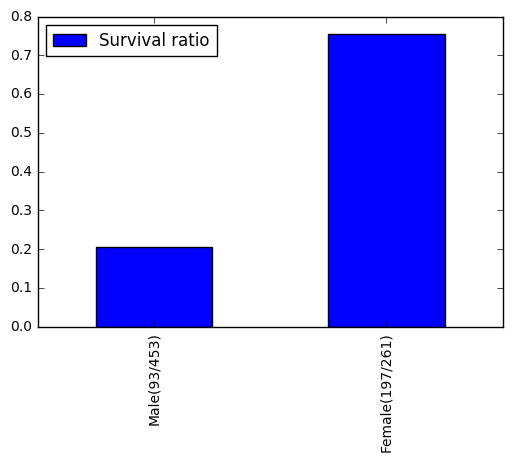

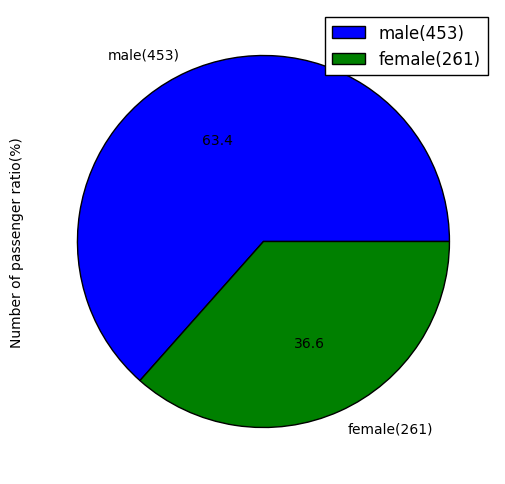

In [29]:
a1, a2, a3 = calc_survival(df, "sex", "male")
b1, b2, b3 = calc_survival(df, "sex", "female")
sex_group_df = pd.DataFrame(
    data={"Survival ratio": [a3, b3]},
    index=["Male", "Female"]
)

%pylab inline
import matplotlib.pyplot as plt

# 绘制直方图
sex_group_df.index = [
    "Male({0}/{1})".format(a1, a2), "Female({0}/{1})".format(b1, b2)
]
sex_group_df.plot(kind="bar")

# 绘制饼图
# sex_group_df.plot.pie(subplots=True, autopct='%.1f', figsize=(6, 6))
sex_num_group_df = pd.DataFrame(
    data={"Number of passenger ratio(%)": [a2, b2]},
   index=["male({0})".format(a2), "female({0})".format(b2)]
)
sex_num_group_df.plot.pie(subplots=True, autopct='%.1f', figsize=(6, 6))

### 3.3. 按level组进行分析
#### 3.3.1. 分组方式
> class1为一组，class2为一组，class3为一组

#### 3.3.2. 分析结果
> 从图中可以看出，class1有216名乘员，class2有184名乘员，class3有491名乘员，其中生还率class1 > class2 > class3

Populating the interactive namespace from numpy and matplotlib


array([<matplotlib.axes._subplots.AxesSubplot object at 0x116417cf8>], dtype=object)

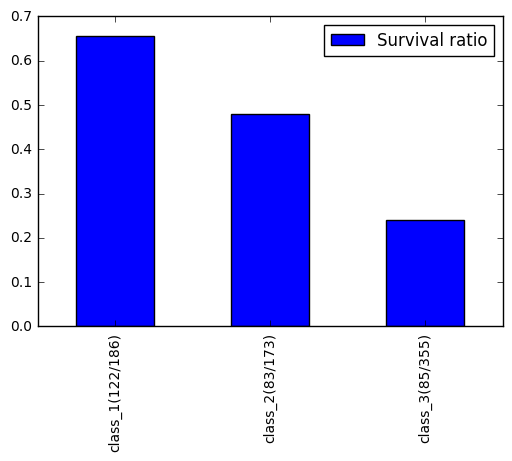

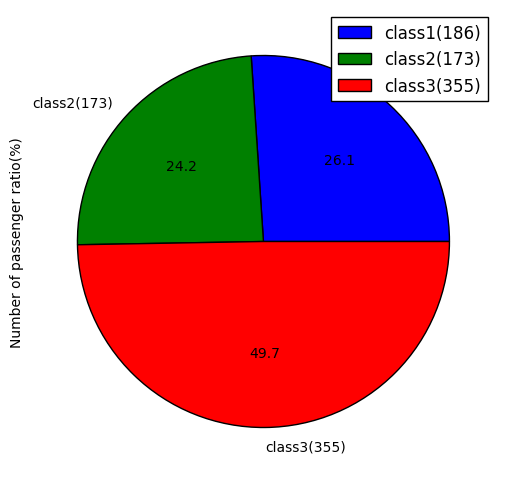

In [30]:
a1, a2, a3 = calc_survival(df, "level", 1)
b1, b2, b3 = calc_survival(df, "level", 2)
c1, c2, c3 = calc_survival(df, "level", 3)
class_group_df = pd.DataFrame(
    data={"Survival ratio": [a3, b3, c3]},
    index=["class 1", "class 2", "class 3"]
)

%pylab inline
import matplotlib.pyplot as plt

# 绘制直方图
class_group_df.index = [
    "class_1({0}/{1})".format(a1, a2), 
    "class_2({0}/{1})".format(b1, b2), 
    "class_3({0}/{1})".format(c1, c2)
]
class_group_df.plot(kind="bar")

# 绘制饼图
#class_group_df.plot.pie(subplots=True, autopct='%.1f', figsize=(6, 6))
class_num_group_df = pd.DataFrame(
    data={"Number of passenger ratio(%)": [a2, b2, c2]},
   index=["class1({0})".format(a2), 
          "class2({0})".format(b2), 
          "class3({0})".format(c2)]
)
class_num_group_df.plot.pie(subplots=True, autopct='%.1f', figsize=(6, 6))

### 3.4. 按age_sex组进行分析
#### 3.4.1. 分组方式
> 按Child，Woman，Man分成三组

#### 3.4.2. 分析结果
> 从图中可以看出，child有139名，woman有192名，man有382名， 其中生还率woman>child>man

Populating the interactive namespace from numpy and matplotlib


array([<matplotlib.axes._subplots.AxesSubplot object at 0x117d09fd0>], dtype=object)

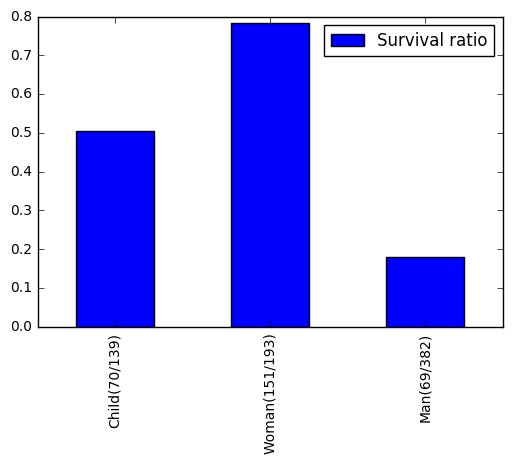

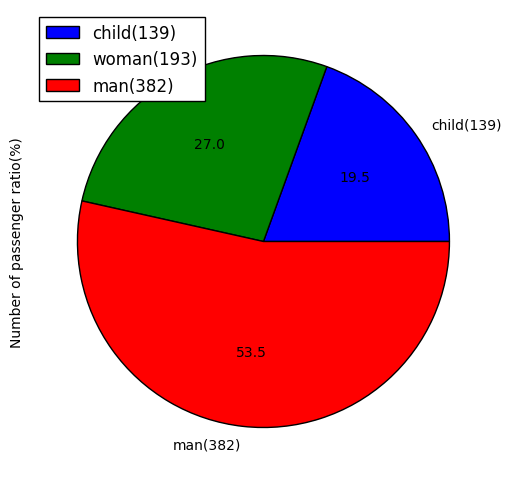

In [31]:
a1, a2, a3 = calc_survival(df, "age_sex", "child")
b1, b2, b3 = calc_survival(df, "age_sex", "woman")
c1, c2, c3 = calc_survival(df, "age_sex", "man")
age_sex_group_df = pd.DataFrame(
    data={"Survival ratio": [a3, b3, c3]},
    index=["Child", "Woman", "Man"]
)

%pylab inline
import matplotlib.pyplot as plt


# 绘制直方图
age_sex_group_df.index = [
    "Child({0}/{1})".format(a1, a2),
    "Woman({0}/{1})".format(b1, b2),
    "Man({0}/{1})".format(c1, c2)
]
age_sex_group_df.plot(kind="bar")

# 绘制饼图
# age_sex_group_df.plot.pie(subplots=True, autopct='%.1f', figsize=(6, 6))
age_sex_num_group_df = pd.DataFrame(
    data={"Number of passenger ratio(%)": [a2, b2, c2]},
   index=["child({0})".format(a2), 
          "woman({0})".format(b2), 
          "man({0})".format(c2)]
)
age_sex_num_group_df.plot.pie(subplots=True, autopct='%.1f', figsize=(6, 6))

### 3.5. 按age+sex+level组进行分析
#### 3.5.1. 分组方式
> Child按class分三组，Woman按class分三组，Man按class分三组，

#### 3.5.2. 分析结果
> 从图可以看出，除了man中class3大约class2，其他乘员级别内都按class顺序排列；woman略高于child，man最低

child_1(14/16)
child_2(23/29)
child_3(33/94)
woman_1(72/74)
woman_2(54/60)
woman_3(25/59)
man_1(36/96)
man_2(6/84)
man_3(27/202)
Populating the interactive namespace from numpy and matplotlib


array([<matplotlib.axes._subplots.AxesSubplot object at 0x117cb2470>], dtype=object)

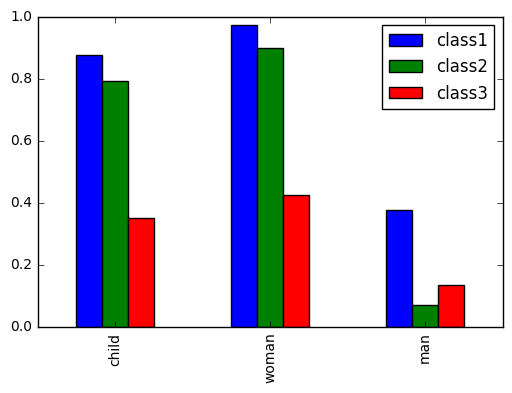

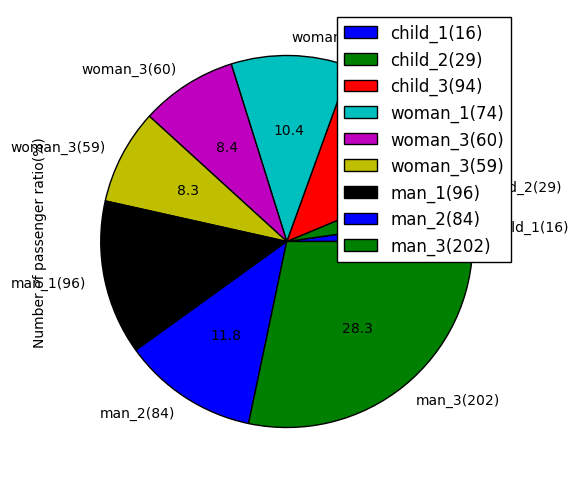

In [32]:
a1, a2, a3 = calc_survival(df, "age_sex_level", "child", 1)
b1, b2, b3 = calc_survival(df, "age_sex_level", "child", 2)
c1, c2, c3 = calc_survival(df, "age_sex_level", "child", 3)
d1, d2, d3 = calc_survival(df, "age_sex_level", "woman", 1)
e1, e2, e3 = calc_survival(df, "age_sex_level", "woman", 2)
f1, f2, f3 = calc_survival(df, "age_sex_level", "woman", 3)
g1, g2, g3 = calc_survival(df, "age_sex_level", "man", 1)
h1, h2, h3 = calc_survival(df, "age_sex_level", "man", 2)
i1, i2, i3 = calc_survival(df, "age_sex_level", "man", 3) 
print("child_1({0}/{1})".format(a1, a2))
print("child_2({0}/{1})".format(b1, b2))
print("child_3({0}/{1})".format(c1, c2))
print("woman_1({0}/{1})".format(d1, d2))
print("woman_2({0}/{1})".format(e1, e2))
print("woman_3({0}/{1})".format(f1, f2))
print("man_1({0}/{1})".format(g1, g2))
print("man_2({0}/{1})".format(h1, h2))
print("man_3({0}/{1})".format(i1, i2))

data = np.array([
            [a3, b3, c3],
            [d3, e3, f3],
            [g3, h3, i3],
            ])

age_class_group_saved_df = pd.DataFrame(
    data=data,
    index=["child", "woman", "man"],
    columns=["class1", "class2", "class3"]
)

%pylab inline
import matplotlib.pyplot as plt

# 绘制直方图
age_class_group_saved_df.index = ["child", "woman", "man"]
age_class_group_saved_df.plot(kind="bar")

# 绘制饼图(按照乘员级别画三个饼图)
# age_class_group_saved_df.plot.pie(subplots=True, autopct='%.1f', figsize=(12, 4))
age_class_name_group_saved_df = pd.DataFrame(
    data={"Number of passenger ratio(%)": [a2, b2, c2, d2, e2, f2, g2, h2, i2]},
   index=[
        "child_1({0})".format(a2), 
        "child_2({0})".format(b2), 
        "child_3({0})".format(c2),
        "woman_1({0})".format(d2), 
        "woman_3({0})".format(e2), 
        "woman_3({0})".format(f2),
        "man_1({0})".format(g2), 
        "man_2({0})".format(h2), 
        "man_3({0})".format(i2),
         ]
)
age_class_name_group_saved_df.plot.pie(subplots=True, autopct='%.1f', figsize=(6, 6))

## 结论
> 1. 儿童和妇女的生还率是高于男子的，儿童、妇女和男子的分类和生还率之间存在相关性。
2. 头等高于二等，二等高于三等，可能是因为头等在船的最上面，三等在最下面；但男子中二等的生还率要低于三等。
3. 对于年龄的处理删除了缺失值，可能删除了有效的数据。
4. 分析中没有使用假设检验，没有检测生存率的区别是否有统计显著性。
5. 该数据样本较小，只有800多人，而泰坦尼克的真实真实人数有两千多。